In [1]:
import pandas as pd

df = pd.read_csv('datasets/weather/temperature.csv')

In [2]:
df.set_index('datetime',inplace=True)

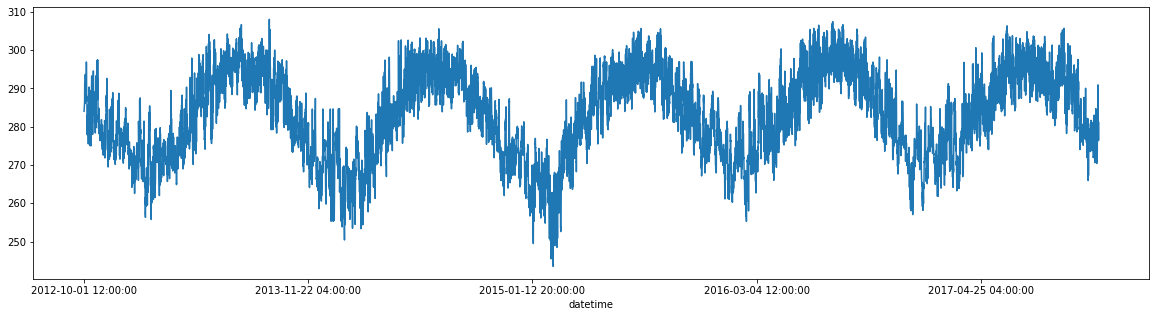

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
df["Detroit"].plot(figsize=(20,5))
plt.show()

In [4]:
selected_columns = df[["Detroit"]]
new_df=selected_columns.copy()
new_df.head()

,Detroit
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.030000
2012-10-01 14:00:00,284.069789
2012-10-01 15:00:00,284.173965
2012-10-01 16:00:00,284.278140


In [5]:
#convert Kelin to Fahrenheit
#T(°F) = T(K) × 9/5 - 459.67
new_df['Detroit'] = new_df['Detroit'] * 9 / 5 - 459.67
new_df.head()

,Detroit
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,51.584000
2012-10-01 14:00:00,51.655621
2012-10-01 15:00:00,51.843136
2012-10-01 16:00:00,52.030652


In [6]:
test_data = new_df.loc['2016-01-01 00:00:00':'2016-03-31 23:00:00',:] 
test_data.info

<bound method DataFrame.info of                        Detroit
datetime                      
2016-01-01 00:00:00  31.162232
2016-01-01 01:00:00  30.884000
2016-01-01 02:00:00  29.065036
2016-01-01 03:00:00  30.380000
2016-01-01 04:00:00  29.678000
...                        ...
2016-03-31 19:00:00  59.360000
2016-03-31 20:00:00  58.042302
2016-03-31 21:00:00  61.358000
2016-03-31 22:00:00  62.078045
2016-03-31 23:00:00  62.816000

[2184 rows x 1 columns]>

In [7]:
testing_data= test_data.values
testing_data.shape

(2184, 1)

In [8]:
# load day-ahead prices of 2020

df1 = pd.read_csv('datasets/DAP/2020/jan_feb.csv')
df2 = pd.read_csv('datasets/DAP/2020/mar_apr.csv')
df3 = pd.read_csv('datasets/DAP/2020/may_jun.csv')

frames =[df1,df2,df3]
one_year_prices = pd.concat(frames)
one_year_prices.info

<bound method DataFrame.info of                  DateTime  day_ahead_pricing (michigan_hub) (miso)
0     2020-01-01 00:00:00                                    18.95
1     2020-01-01 01:00:00                                    18.34
2     2020-01-01 02:00:00                                    17.46
3     2020-01-01 03:00:00                                    17.36
4     2020-01-01 04:00:00                                    16.67
...                   ...                                      ...
1459  2020-06-30 19:00:00                                    41.58
1460  2020-06-30 20:00:00                                    32.08
1461  2020-06-30 21:00:00                                    29.04
1462  2020-06-30 22:00:00                                    26.27
1463  2020-06-30 23:00:00                                    23.49

[4368 rows x 2 columns]>

In [9]:
import numpy as np

# convert prices to cents/kWh
one_year_prices.set_index("DateTime", inplace=True)
one_year_prices["day_ahead_pricing (michigan_hub) (miso)"] = one_year_prices["day_ahead_pricing (michigan_hub) (miso)"] / 10
tempt = one_year_prices["day_ahead_pricing (michigan_hub) (miso)"].values # one_year_price is dataframe, we have to convert to numpy array
one_year_price = np.array(tempt).reshape(-1,1)
one_year_price.shape

(4368, 1)

In [10]:
import tensorflow as tf
from tensorflow import keras

# this DNN was found by fine-tuning hyperparameter using RandomSearchCV
model = keras.models.load_model("RandomSCV_3_layer_60_neurons")

In [11]:
# this function returns hourly power consumption and temperature of each hour in a day by using DNN of imitation learning

def testing_model(test_data, test_prices):
    hvac_energy_day = []
    temperature_day = []
    T = test_data[0][0]
    for k in range(24): # max_step = 24
        input=[]
        input.append(test_data[k][0])
        input.append(T)
        input.append(test_prices[k][0])
        input.append(k)
        data = np.array(input).reshape(-1,4)
        hvac_energy = model.predict(data)
        
        action = hvac_energy[0][0]
        if action < 0:
            action = 0
        if action > 15:
            action = 15
            
        hvac_energy_day.append(action)
        T = 0.7 * T + (1-0.7)*(test_data[k][0]+(2.5 / 0.14) * action)
        temperature_day.append(T)
    return np.array(hvac_energy_day), np.array(temperature_day)

In [12]:
#calculating optimal results of each day of testing dataset by using MILP solver

from mip import Model, xsum, BINARY

def action_by_mip(T_out, price):
    # price of main grid--------------------------------------------------------------------------------------------------------
    #price_Grid = [10, 10, 8.5, 9, 12, 9.2, 12.2, 24.5, 27, 27.5, 17.2, 16.5, 16.5, 16.2, 14, 9, 8.5, 8.7, 9.5, 8, 8.2, 8, 8.1, 8.1]
    number_time_slot = 24

    m = Model()

    # definition of variables of HVAC system -----------------------------------
    T_min = 66.2 # 19 C
    T_max = 75.2 # 24 C
    T = [m.add_var() for i in range(number_time_slot + 1)]
    y = [m.add_var(var_type=BINARY) for i in range(number_time_slot+1)]
    T[0] = T_out[0]
    x1 =[m.add_var() for i in range(number_time_slot + 1)]
    x1[0]=0
    x2 =[m.add_var() for i in range(number_time_slot + 1)]
    x2[0]=0
    x3 =[m.add_var() for i in range(number_time_slot + 1)]
    x3[0]=0
    w1 =[m.add_var(var_type=BINARY) for i in range(number_time_slot + 1)]
    w1[0]=0
    w2 =[m.add_var(var_type=BINARY) for i in range(number_time_slot + 1)]
    w2[0]=0
    w3 =[m.add_var(var_type=BINARY) for i in range(number_time_slot + 1)]
    w3[0]=0
    HVAC_energy = [m.add_var(lb=0, ub=15) for i in range(number_time_slot)]
    weight_coefficient = 4

    # definition of objective function --------------------------------------------------------------------------------
    m.objective = xsum(HVAC_energy[i] * price[i] + weight_coefficient * (T_min * w1[i+1] - x1[i+1] + x3[i+1] - T_max * w3[i+1]) for i in range(number_time_slot))
    
    for i in range(number_time_slot):
        m += T[i+1] == 0.7 * T[i] + (1 - 0.7) * (T_out[i] + (2.5 / 0.14) * HVAC_energy[i])

    for i in range(number_time_slot+1):
        m += T_max <= T[i] - 0.001 + 1000 * (1-y[i])
        m += T_max >= T[i] - 1000 * y[i]

    for i in range(number_time_slot):
        m += HVAC_energy[i] <= 0 + 1000 * (1 - y[i])
        m += HVAC_energy[i] >= 0 - 1000 * (1 - y[i])
        
    for i in range(number_time_slot):
        m += 1 == w1[i+1] + w2[i+1] + w3[i+1]
        m += T[i+1] == x1[i+1] + x2[i+1] + x3[i+1]

    for i in range(number_time_slot):
        m += x1[i+1] <= T_min * w1[i+1]
        m += x1[i+1] >= -1000 * w1[i+1]

    for i in range(number_time_slot):
        m += x2[i+1] <= T_max * w2[i+1]
        m += x2[i+1] >= T_min * w2[i+1]

    for i in range(number_time_slot):
        m += x3[i+1] <= 1000 * w3[i+1]
        m += x3[i+1] >= T_max * w3[i+1]

    
    m.optimize()
    #print("the minimum value --------------------------------------------------------------------------")
    #print("optimal value =", m.objective_value)
    #print("temperature----------------------------------")
    T_in = []
    for i in range(number_time_slot):
        #print(i+1,"=",T[i+1].x)
        T_in.append(T[i+1].x)
    #print("HVAC energy ----------------------------------")
    HVAC = []
    for i in range(number_time_slot):
    #    print(i,"=", HVAC_energy[i].x)
        HVAC.append(HVAC_energy[i].x)
    
    return np.array(HVAC), np.array(T_in), m.objective_value

best_HVAC_energy_testing=[]
best_tem_testing=[]
for i in range(0,testing_data.shape[0], 24):
    tempt1, tempt2, tempt3 = action_by_mip(testing_data[i: i + 24].ravel(), one_year_price[i: i + 24].ravel())
    best_HVAC_energy_testing.append(tempt1)
    best_tem_testing.append(tempt2)

best_energy_testing = np.array(best_HVAC_energy_testing)
best_temperature_testing = np.array(best_tem_testing)


In [13]:
from sklearn.metrics import mean_absolute_error

def mape_vectorized(a, b): 
    mask = a != 0
    return np.mean(np.fabs(a[mask] - b[mask])/a[mask])*100

# calculating and comparing the hourly power consumption of each day in imitation learning and optimal results of MILP solver
total_hvac_energy = []
total_temperature = []
total_mae = 0
total_mape = 0
for i in range(91):
    test_data = testing_data[i*24:i*24+24]
    test_prices = one_year_price[i*24:i*24+24]
    hvac_energy_day, temperature_day = testing_model(test_data,test_prices)
    total_hvac_energy.append(hvac_energy_day)
    total_temperature.append(temperature_day)
    mae1 = mean_absolute_error(best_energy_testing[i], hvac_energy_day.ravel())
    total_mae = total_mae + mae1
    mape1 = mape_vectorized(best_energy_testing[i], hvac_energy_day.ravel())
    total_mape = total_mape + mape1
    print("i=",i,"mae=",mae1, "mape=",mape1)
print("average mape", total_mae/91, "average mape", total_mape/91)

i= 0 mae= 0.0015836437722732504 mape= 0.0645187765117685
i= 1 mae= 0.0015439469376827553 mape= 0.06704522823384826
i= 2 mae= 0.0016542606676363074 mape= 0.07620126443775724
i= 3 mae= 0.001744456887334082 mape= 0.06825422720381268
i= 4 mae= 0.0017659123405248296 mape= 0.05872553775206938
i= 5 mae= 0.0021346057739925575 mape= 0.08717589948376453
i= 6 mae= 0.12085239677639888 mape= 6.925512803658086
i= 7 mae= 0.0025015141558745826 mape= 0.12877026761265126
i= 8 mae= 0.002410985209619724 mape= 0.1605860313278069
i= 9 mae= 0.0021998583289757068 mape= 0.09808611902648573
i= 10 mae= 0.0013539851929544877 mape= 0.04140423051882273
i= 11 mae= 0.002318166599499775 mape= 0.09052745294249144
i= 12 mae= 0.0015793445401506845 mape= 0.05069667685705857
i= 13 mae= 0.0016890714456343676 mape= 0.0701435236652973
i= 14 mae= 0.002321345832388022 mape= 0.1097282760845273
i= 15 mae= 0.0029001706389020867 mape= 0.15505446252364702
i= 16 mae= 0.001517003707354229 mape= 0.0546429194420459
i= 17 mae= 0.00110953

In [14]:
# calculating and comparing the daily energy cost of imitation learning and optimal cost of MILP solver
total_cost_mae = 0
total_cost_mape = 0
for i in range(91):
    energy_cost_model = 0
    energy_cost_milp = 0
    for j in range(24):
        energy_cost_model += total_hvac_energy[i][j] * one_year_price[i*24 + j]
        energy_cost_milp += best_energy_testing[i][j] * one_year_price[i*24 + j]
    mae1 = np.fabs(energy_cost_milp - energy_cost_model)
    total_cost_mae = total_cost_mae + mae1
    mape1 = np.fabs(energy_cost_milp - energy_cost_model) / energy_cost_milp * 100
    total_cost_mape = total_cost_mape + mape1
    print("i=",i,"milp =",energy_cost_milp,"model=", energy_cost_model, "mae=",mae1, "mape=",mape1)
print("average mape of total cost", total_cost_mae/91, "average mape of total cost", total_cost_mape/91)

i= 0 milp = [128.21770793] model= [128.2192184] mae= [0.00151047] mape= [0.00117805]
i= 1 milp = [121.7736094] model= [121.76632738] mae= [0.00728202] mape= [0.00597997]
i= 2 milp = [111.79494807] model= [111.77502737] mae= [0.0199207] mape= [0.01781896]
i= 3 milp = [128.63497068] model= [128.58888162] mae= [0.04608907] mape= [0.03582934]
i= 4 milp = [164.72386835] model= [164.74184543] mae= [0.01797709] mape= [0.01091347]
i= 5 milp = [143.76466221] model= [143.79693204] mae= [0.03226983] mape= [0.02244629]
i= 6 milp = [123.88192839] model= [124.02833823] mae= [0.14640984] mape= [0.11818499]
i= 7 milp = [108.66476472] model= [108.66877042] mae= [0.0040057] mape= [0.00368629]
i= 8 milp = [83.78098534] model= [83.82141392] mae= [0.04042858] mape= [0.04825508]
i= 9 milp = [89.48939393] model= [89.4736496] mae= [0.01574433] mape= [0.01759351]
i= 10 milp = [154.5102354] model= [154.46101195] mae= [0.04922344] mape= [0.03185772]
i= 11 milp = [175.86134258] model= [175.96087405] mae= [0.09953